In [2]:
import os
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import PIL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report

PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True


# Loading Data

In [3]:
class CancerDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ["Normal cases", "Benign cases", "Malignant cases"]  # List the directories (class folders)
        self.image_paths = []  # Store the paths of images
        self.labels = []       # Store the labels corresponding to images

        for label, class_name in enumerate(self.classes): # for each class (Normal = 0, Benign = 1, Malignant = 2)
            class_folder = os.path.join(data_dir, class_name)
            if os.path.isdir(class_folder):
                for file_name in os.listdir(class_folder):
                    if file_name.endswith(('.jpg', '.png', '.jpeg')):  # image datatypes
                        self.image_paths.append(os.path.join(class_folder, file_name)) # append images
                        self.labels.append(label) # append associated labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.image_paths[idx]
        image = PIL.Image.open(img_path)

        # Apply any transformations (if defined)
        if self.transform:
            image = self.transform(image)

        # Return the image and the label
        label = self.labels[idx]
        return image, label



In [4]:
img_transform = transforms.Compose([
    transforms.Resize((128, 128)), # resizing (scaled down)
    transforms.Grayscale(),
    transforms.ToTensor()   # convert image to a tensor
])


cancer_dataset = CancerDataset("../data", img_transform)
print(f'Img Shape: {cancer_dataset[0][0].shape}')

print(f'Dataset Size: {len(cancer_dataset)}')
label_map = {0 : "Normal", 1 : "Benign", 2 : "Malignant"}
cts = np.unique(cancer_dataset.labels, return_counts = True)
for i in cts[0]:
    label = label_map[i]
    print(f'{label} Count: {cts[1][i]}, Percent: {100*cts[1][i]/len(cancer_dataset):.2f}')

Img Shape: torch.Size([1, 128, 128])
Dataset Size: 1097
Normal Count: 416, Percent: 37.92
Benign Count: 120, Percent: 10.94
Malignant Count: 561, Percent: 51.14


In [5]:
torch.manual_seed(35)  # set seed

train_proportion = 0.7 # percent training set

train_size = int(train_proportion * len(cancer_dataset)) 
test_size = len(cancer_dataset) - train_size 

train_dataset, test_dataset = random_split(cancer_dataset, [train_size, test_size]) # split dataset into train and test

In [6]:
print(f'Test Set Size: {len(test_dataset.indices)}')
cts = np.unique([cancer_dataset[i][1] for i in test_dataset.indices], return_counts = True)
for i in cts[0]:
    label = label_map[i]
    print(f'Test {label} Count: {cts[1][i]}, Percent: {100*cts[1][i]/len(test_dataset.indices):.2f}')

Test Set Size: 330
Test Normal Count: 130, Percent: 39.39
Test Benign Count: 37, Percent: 11.21
Test Malignant Count: 163, Percent: 49.39


In [7]:
# initialize dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modeling

In [14]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        # dense layers
        self.linear1 = nn.Linear(128*128, 64*64)
        self.linear2 = nn.Linear(64*64, 3)

        self.relu = nn.ReLU()
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [15]:
model = MLP()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_epochs = 20
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

cpu


In [16]:
results = []
for epoch in range(1, num_epochs+1):
    model.train()  # set model to train
    running_loss = 0.0
    
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).long()

        # zero out gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    model.eval() # set model to evaluation mode
    
    valid_loss = 0.0
    for images, labels in test_dataloader:
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()

    avg_loss = running_loss / len(train_dataloader)
    avg_valid_loss = valid_loss / len(test_dataloader)
    results.append([epoch, avg_loss, avg_valid_loss])
    if i%2 == 0:
        print(f"Train Loss: {avg_loss:.4f}")
        print(f"Valid Loss: {avg_valid_loss:.4f}")



Epoch 1/20: 100%|██████████| 24/24 [00:04<00:00,  5.49it/s]


Train Loss: 3.8587
Valid Loss: 1.2269


Epoch 2/20: 100%|██████████| 24/24 [00:04<00:00,  5.73it/s]


Train Loss: 0.6469
Valid Loss: 0.3943


Epoch 3/20: 100%|██████████| 24/24 [00:04<00:00,  5.66it/s]


Train Loss: 0.3685
Valid Loss: 0.4743


Epoch 4/20: 100%|██████████| 24/24 [00:04<00:00,  5.64it/s]


Train Loss: 0.2528
Valid Loss: 0.2131


Epoch 5/20: 100%|██████████| 24/24 [00:04<00:00,  5.64it/s]


Train Loss: 0.1185
Valid Loss: 0.1417


Epoch 6/20: 100%|██████████| 24/24 [00:04<00:00,  5.61it/s]


Train Loss: 0.0915
Valid Loss: 0.1288


Epoch 7/20: 100%|██████████| 24/24 [00:04<00:00,  5.56it/s]


Train Loss: 0.1524
Valid Loss: 0.5170


Epoch 8/20: 100%|██████████| 24/24 [00:04<00:00,  5.51it/s]


Train Loss: 0.1359
Valid Loss: 0.1136


Epoch 9/20: 100%|██████████| 24/24 [00:04<00:00,  5.47it/s]


Train Loss: 0.0466
Valid Loss: 0.0797


Epoch 10/20: 100%|██████████| 24/24 [00:04<00:00,  5.08it/s]


Train Loss: 0.0496
Valid Loss: 0.1394


Epoch 11/20: 100%|██████████| 24/24 [00:04<00:00,  5.42it/s]


Train Loss: 0.0445
Valid Loss: 0.0657


Epoch 12/20: 100%|██████████| 24/24 [00:04<00:00,  5.26it/s]


Train Loss: 0.4471
Valid Loss: 0.4656


Epoch 13/20: 100%|██████████| 24/24 [00:04<00:00,  5.39it/s]


Train Loss: 0.3815
Valid Loss: 0.1540


Epoch 14/20: 100%|██████████| 24/24 [00:04<00:00,  5.41it/s]


Train Loss: 0.1027
Valid Loss: 0.0785


Epoch 15/20: 100%|██████████| 24/24 [00:04<00:00,  5.26it/s]


Train Loss: 0.0538
Valid Loss: 0.0931


Epoch 16/20: 100%|██████████| 24/24 [00:04<00:00,  5.37it/s]


Train Loss: 0.0472
Valid Loss: 0.1470


Epoch 17/20: 100%|██████████| 24/24 [00:04<00:00,  5.37it/s]


Train Loss: 0.0828
Valid Loss: 0.1130


Epoch 18/20: 100%|██████████| 24/24 [00:04<00:00,  5.31it/s]


Train Loss: 0.1014
Valid Loss: 0.0508


Epoch 19/20: 100%|██████████| 24/24 [00:04<00:00,  5.04it/s]


Train Loss: 0.0562
Valid Loss: 0.0736


Epoch 20/20: 100%|██████████| 24/24 [00:04<00:00,  5.07it/s]


Train Loss: 0.0556
Valid Loss: 0.0733


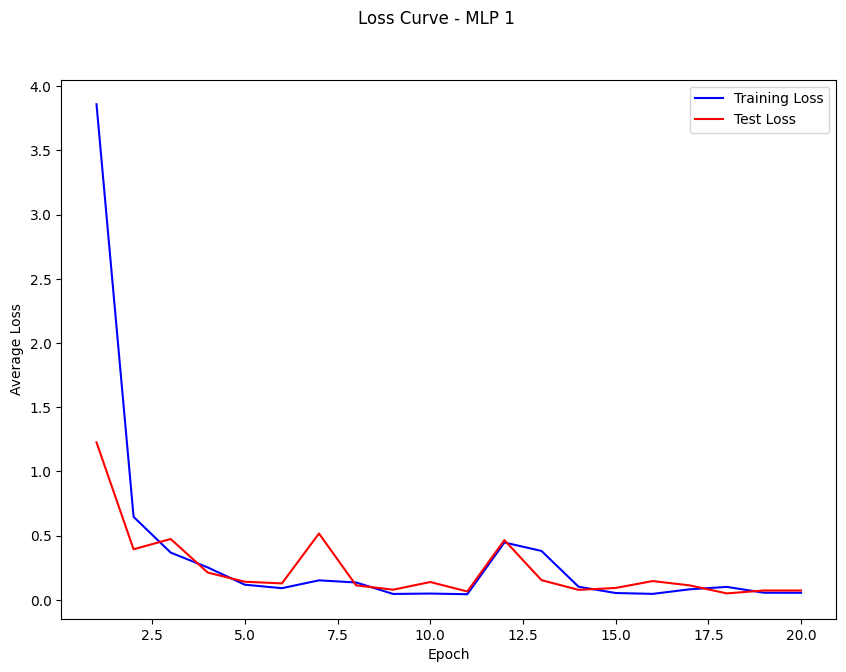

In [18]:
arr_results = np.array(results)
fig = plt.figure(figsize = (10,7))
plt.plot(arr_results[:, 0], arr_results[:, 1], label = 'Training Loss', c = 'b')
plt.plot(arr_results[:, 0], arr_results[:, 2], label = 'Test Loss', c = 'r')
plt.suptitle('Loss Curve - MLP 1')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

In [19]:
y_test = []
y_pred_prob = []
y_pred = []
for images, labels in test_dataloader:
    scores = model(images) # get scores from model
    pred_prob = F.softmax(scores, dim = 1) # get predicted probabilities
    preds = torch.argmax(pred_prob, axis = 1) # get predicted class

    # append to list for entire test set
    y_test.extend(labels.detach().numpy())
    y_pred_prob.extend(pred_prob.detach().numpy())
    y_pred.extend(preds.detach().numpy())

Accuracy: 0.9696969696969697
Overall ROC AUC: 0.9990694266069693
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       130
           1       1.00      0.76      0.86        37
           2       0.98      1.00      0.99       163

    accuracy                           0.97       330
   macro avg       0.98      0.92      0.94       330
weighted avg       0.97      0.97      0.97       330



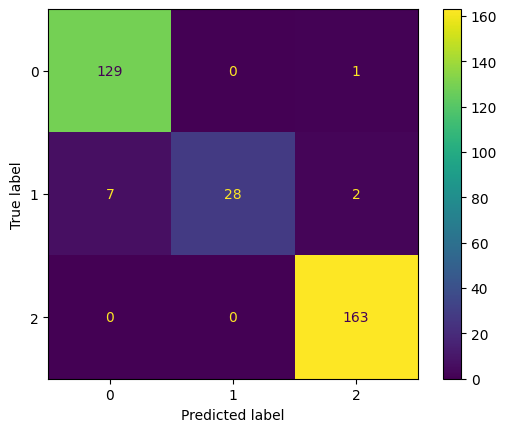

In [20]:
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class = 'ovr')

print(f'Accuracy: {acc}')
print(f'Overall ROC AUC: {roc_auc}')

print(classification_report(y_test, y_pred))    

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [28]:
class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()

        # dense layers
        self.linear1 = nn.Linear(128*128, 64*64)
        self.linear2 = nn.Linear(64*64, 3)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.tanh(self.linear1(x))
        x = self.linear2(x)
        return x

In [29]:
model = MLP2()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_epochs = 20
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

cpu


In [30]:
results = []
for epoch in range(1, num_epochs+1):
    model.train()  # set model to train
    running_loss = 0.0
    
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device).long()

        # zero out gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    model.eval() # set model to evaluation mode
    
    valid_loss = 0.0
    for images, labels in test_dataloader:
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        valid_loss += loss.item()

    avg_loss = running_loss / len(train_dataloader)
    avg_valid_loss = valid_loss / len(test_dataloader)
    results.append([epoch, avg_loss, avg_valid_loss])
    if i%2 == 0:
        print(f"Train Loss: {avg_loss:.4f}")
        print(f"Valid Loss: {avg_valid_loss:.4f}")



Epoch 1/20: 100%|██████████| 24/24 [00:04<00:00,  5.53it/s]


Train Loss: 2.4254
Valid Loss: 1.5834


Epoch 2/20: 100%|██████████| 24/24 [00:04<00:00,  5.50it/s]


Train Loss: 1.0940
Valid Loss: 1.0517


Epoch 3/20: 100%|██████████| 24/24 [00:04<00:00,  5.63it/s]


Train Loss: 0.9150
Valid Loss: 0.8141


Epoch 4/20: 100%|██████████| 24/24 [00:04<00:00,  5.53it/s]


Train Loss: 0.8643
Valid Loss: 0.8490


Epoch 5/20: 100%|██████████| 24/24 [00:04<00:00,  5.51it/s]


Train Loss: 0.6957
Valid Loss: 0.7820


Epoch 6/20: 100%|██████████| 24/24 [00:04<00:00,  5.47it/s]


Train Loss: 0.6144
Valid Loss: 0.6054


Epoch 7/20: 100%|██████████| 24/24 [00:04<00:00,  5.41it/s]


Train Loss: 0.6213
Valid Loss: 0.7389


Epoch 8/20: 100%|██████████| 24/24 [00:04<00:00,  5.43it/s]


Train Loss: 0.5728
Valid Loss: 0.5633


Epoch 9/20: 100%|██████████| 24/24 [00:04<00:00,  5.39it/s]


Train Loss: 0.5849
Valid Loss: 0.5473


Epoch 10/20: 100%|██████████| 24/24 [00:04<00:00,  5.36it/s]


Train Loss: 0.5732
Valid Loss: 0.5288


Epoch 11/20: 100%|██████████| 24/24 [00:04<00:00,  5.34it/s]


Train Loss: 0.4970
Valid Loss: 0.5126


Epoch 12/20: 100%|██████████| 24/24 [00:04<00:00,  5.35it/s]


Train Loss: 0.4517
Valid Loss: 0.4597


Epoch 13/20: 100%|██████████| 24/24 [00:04<00:00,  5.32it/s]


Train Loss: 0.4756
Valid Loss: 0.4458


Epoch 14/20: 100%|██████████| 24/24 [00:04<00:00,  5.29it/s]


Train Loss: 0.4193
Valid Loss: 0.3862


Epoch 15/20: 100%|██████████| 24/24 [00:04<00:00,  5.31it/s]


Train Loss: 0.4089
Valid Loss: 0.3776


Epoch 16/20: 100%|██████████| 24/24 [00:04<00:00,  5.15it/s]


Train Loss: 0.3571
Valid Loss: 0.3616


Epoch 17/20: 100%|██████████| 24/24 [00:04<00:00,  5.02it/s]


Train Loss: 0.3394
Valid Loss: 0.3813


Epoch 18/20: 100%|██████████| 24/24 [00:04<00:00,  5.02it/s]


Train Loss: 0.3712
Valid Loss: 0.4331


Epoch 19/20: 100%|██████████| 24/24 [00:04<00:00,  5.07it/s]


Train Loss: 0.3468
Valid Loss: 0.3865


Epoch 20/20: 100%|██████████| 24/24 [00:04<00:00,  5.05it/s]


Train Loss: 0.3433
Valid Loss: 0.4008


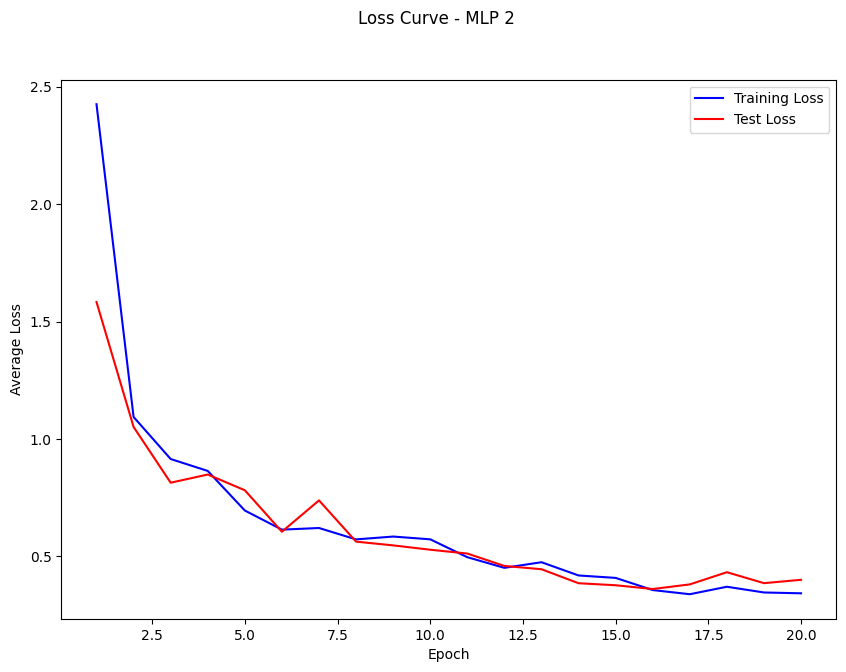

In [31]:
arr_results = np.array(results)
fig = plt.figure(figsize = (10,7))
plt.plot(arr_results[:, 0], arr_results[:, 1], label = 'Training Loss', c = 'b')
plt.plot(arr_results[:, 0], arr_results[:, 2], label = 'Test Loss', c = 'r')
plt.suptitle('Loss Curve - MLP 2')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

In [32]:
y_test = []
y_pred_prob = []
y_pred = []
for images, labels in test_dataloader:
    scores = model(images) # get scores from model
    pred_prob = F.softmax(scores, dim = 1) # get predicted probabilities
    preds = torch.argmax(pred_prob, axis = 1) # get predicted class

    # append to list for entire test set
    y_test.extend(labels.detach().numpy())
    y_pred_prob.extend(pred_prob.detach().numpy())
    y_pred.extend(preds.detach().numpy())

Accuracy: 0.8727272727272727
Overall ROC AUC: 0.9052144673839763
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       130
           1       0.00      0.00      0.00        37
           2       1.00      0.97      0.98       163

    accuracy                           0.87       330
   macro avg       0.59      0.66      0.62       330
weighted avg       0.79      0.87      0.83       330



/Users/timlanthier/.pyenv/versions/CS273P/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/timlanthier/.pyenv/versions/CS273P/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/timlanthier/.pyenv/versions/CS273P/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

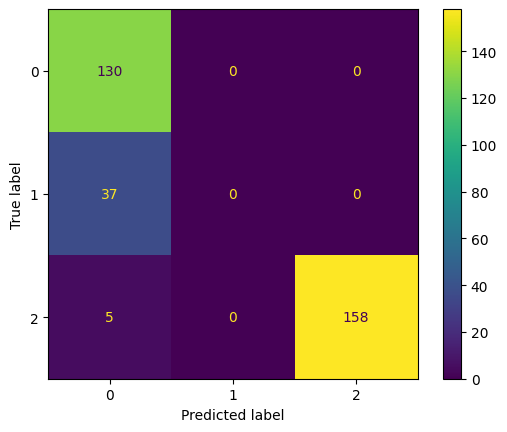

In [33]:
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class = 'ovr')

print(f'Accuracy: {acc}')
print(f'Overall ROC AUC: {roc_auc}')

print(classification_report(y_test, y_pred))    

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

With tanh activation function, our model has significantly worse performance. Classified all benign cases as normal as well as a few malignant cases as normal. This is behavior we wish to avoid.